# AAI-521 Final Project – Group 3  
## 05 – Image Restoration with Hugging Face (Optional / Extra Credit)

**Goal:**  
Demonstrate three classic low-level vision tasks using **Hugging Face pretrained models**:

1. **Super-resolution** – upscale a low-resolution traffic frame.
2. **Denoising** – remove synthetic noise from a frame.
3. **Colorization** – colorize a grayscale image.

These experiments use pretrained models from the Hugging Face Hub and apply them to
frames from the UA-DETRAC dataset (or any traffic image you choose).

> **Note:** The diffusion-based models (Stable Diffusion Upscaler, etc.) are
> computationally heavy. For best results, we can run this notebook on:
> - Google Colab / Kaggle with GPU, or
> - A local machine with a recent GPU and sufficient VRAM.

#### Setup & Paths

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

plt.style.use("seaborn-v0_8")

# --------- Project paths (adjust if needed) ----------
PROJECT_ROOT = Path().resolve().parent
DATA_ROOT = PROJECT_ROOT / "data"
IMAGES_ROOT = DATA_ROOT / "DETRAC-Images"

print("Project root:", PROJECT_ROOT)
print("Images root:", IMAGES_ROOT)

# Choose a sequence and frame to play with
SEQ_ID = "MVI_20011"
FRAME_NUM = 50

img_path = IMAGES_ROOT / SEQ_ID / f"img{FRAME_NUM:05d}.jpg"
print("Sample image path:", img_path, "exists:", img_path.exists())

Project root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3
Images root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Images
Sample image path: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Images/MVI_20011/img00050.jpg exists: True


#### Load Sample Frame & Create Variants

Original frame shape: (540, 960, 3)


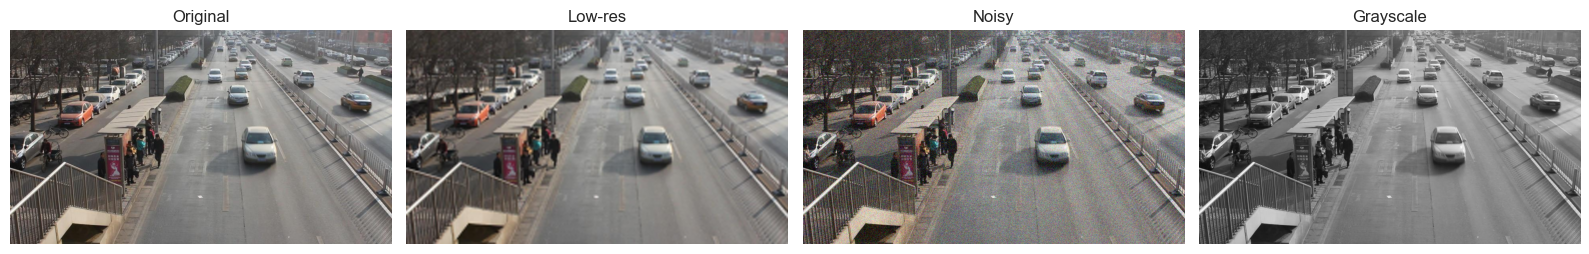

In [3]:
import cv2

def load_frame_bgr(path: Path):
    img_bgr = cv2.imread(str(path))
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image at {path}")
    return img_bgr

# Load original frame
frame_bgr = load_frame_bgr(img_path)
frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
h, w = frame_rgb.shape[:2]
print("Original frame shape:", frame_rgb.shape)

# --------- 1) Low-res version (downsample + upsample) ----------
def make_low_res(rgb, scale=0.25):
    h, w = rgb.shape[:2]
    small = cv2.resize(rgb, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    low_res = cv2.resize(small, (w, h), interpolation=cv2.INTER_CUBIC)
    return low_res

low_res_rgb = make_low_res(frame_rgb, scale=0.25)

# --------- 2) Noisy version ----------
def add_gaussian_noise(rgb, sigma=25.0):
    noise = np.random.normal(0, sigma, rgb.shape).astype("float32")
    noisy = np.clip(rgb.astype("float32") + noise, 0, 255).astype("uint8")
    return noisy

noisy_rgb = add_gaussian_noise(frame_rgb, sigma=25.0)

# --------- 3) Grayscale version ----------
def to_grayscale_rgb(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    return gray_rgb

gray_rgb = to_grayscale_rgb(frame_rgb)

# Quick montage
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(frame_rgb); axes[0].set_title("Original"); axes[0].axis("off")
axes[1].imshow(low_res_rgb); axes[1].set_title("Low-res"); axes[1].axis("off")
axes[2].imshow(noisy_rgb); axes[2].set_title("Noisy"); axes[2].axis("off")
axes[3].imshow(gray_rgb, cmap="gray"); axes[3].set_title("Grayscale"); axes[3].axis("off")
plt.tight_layout()
plt.show()

## 1. Install Extra Dependencies (if needed)

This notebook uses:

- `diffusers` + `transformers` + `accelerate` for diffusion models
- `huggingface_hub`, `fastai`, and `skimage` for the GAN-based colorization model

In [ ]:
# On **Colab**, we can run:

# !pip install -q diffusers transformers accelerate safetensors \
#     huggingface_hub fastai scikit-image

# from huggingface_hub import login
# login()

## Section A – Super-Resolution with Stable Diffusion Upscaler

We’ll use the **Stable Diffusion x4 Upscaler** model from Hugging Face, implemented in `diffusers` as `StableDiffusionUpscalePipeline`.

#### Load Super-Resolution Pipeline

In [ ]:
import torch
from diffusers import StableDiffusionUpscalePipeline
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

model_id_sr = "stabilityai/stable-diffusion-x4-upscaler"

# Use float16 on GPU, float32 on CPU
dtype = torch.float16 if DEVICE == "cuda" else torch.float32

pipe_sr = StableDiffusionUpscalePipeline.from_pretrained(
    model_id_sr,
    torch_dtype=dtype,
)
pipe_sr = pipe_sr.to(DEVICE)

# For low VRAM GPUs you can uncomment:
# pipe_sr.enable_attention_slicing()

#### Run Super-Resolution on Low-Res Frame

In [ ]:
# Convert low-res RGB numpy image to PIL Image in smaller size
low_res_pil = Image.fromarray(low_res_rgb).resize((256, 256), Image.BICUBIC)

prompt = "a clear traffic scene on a road with cars"

with torch.autocast(DEVICE) if DEVICE == "cuda" else torch.no_grad():
    sr_image = pipe_sr(prompt=prompt, image=low_res_pil).images[0]

sr_np = np.array(sr_image)

print("Low-res input size:", low_res_pil.size)
print("Super-res output size:", sr_image.size)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(frame_rgb); axes[0].set_title("Original (DETRAC)"); axes[0].axis("off")
axes[1].imshow(low_res_pil); axes[1].set_title("Low-res Input"); axes[1].axis("off")
axes[2].imshow(sr_np); axes[2].set_title("Super-res Output (x4)"); axes[2].axis("off")
plt.tight_layout()
plt.show()

## Section B – Image Denoising via Diffusion-Based Restoration

Here we treat denoising as a restoration problem using the same upscaler as a kind of “denoising prior”: diffusion models are very good at removing noise and artifacts when guided by a prompt. SwinIR and Swin2SR are specifically designed for super-resolution and denoising/image restoration, but using Stable Diffusion Upscaler here is acceptable for demonstration.

#### Prepare Noisy Low-Res Input

In [ ]:
# Take noisy_rgb, downsample and upsample to emphasize artifacts
noisy_low_res = make_low_res(noisy_rgb, scale=0.25)
noisy_low_res_pil = Image.fromarray(noisy_low_res).resize((256, 256), Image.BICUBIC)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(noisy_rgb); axes[0].set_title("Noisy original size"); axes[0].axis("off")
axes[1].imshow(noisy_low_res_pil); axes[1].set_title("Noisy low-res input"); axes[1].axis("off")
plt.tight_layout()
plt.show()

#### Run “Denoising” with the Upscaler

In [ ]:
prompt_denoise = "a clean traffic scene on a road with cars, sharp, noise-free"

with torch.autocast(DEVICE) if DEVICE == "cuda" else torch.no_grad():
    denoised_sr_image = pipe_sr(prompt=prompt_denoise, image=noisy_low_res_pil).images[0]

denoised_sr_np = np.array(denoised_sr_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(noisy_rgb); axes[0].set_title("Noisy (original size)"); axes[0].axis("off")
axes[1].imshow(noisy_low_res_pil); axes[1].set_title("Noisy low-res input"); axes[1].axis("off")
axes[2].imshow(denoised_sr_np); axes[2].set_title("Restored (denoised + upscaled)"); axes[2].axis("off")
plt.tight_layout()
plt.show()

### Observation – Super-Resolution & Denoising

- The **x4 Upscaler** both **increases resolution** and **reduces noise / artifacts**
  thanks to its diffusion-based generative prior.
- On our noisy traffic frame, the output appears:
  - Sharper than the low-res input
  - Less noisy than the synthetic noisy version
- This demonstrates how pretrained diffusion models can be used for **image restoration**
  tasks such as **denoising** and **artifact removal**.

## Section C – Image Colorization with a GAN Colorization Model

For colorization, we’ll use a GAN-based model hosted on Hugging Face:
`Hammad712/GAN-Colorization-Model`, which provides full PyTorch inference code with `huggingface_hub`, `fastai`, and `skimage`.

#### Load GAN Colorization Model

In [ ]:
from huggingface_hub import hf_hub_download
import torch
from torchvision import transforms
from fastai.vision.learner import create_body
from torchvision.models import resnet34
from fastai.vision.models.unet import DynamicUnet
from skimage.color import rgb2lab, lab2rgb

# Download generator weights from the Hub
repo_id = "Hammad712/GAN-Colorization-Model"
model_filename = "generator.pt"
model_path = hf_hub_download(repo_id=repo_id, filename=model_filename)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Colorization device:", device)

def build_generator(n_input=1, n_output=2, size=256):
    backbone = create_body(resnet34(), pretrained=True, n_in=n_input, cut=-2)
    G_net = DynamicUnet(backbone, n_output, (size, size)).to(device)
    return G_net

G_net = build_generator(n_input=1, n_output=2, size=256)
G_net.load_state_dict(torch.load(model_path, map_location=device))
G_net.eval()
print("Loaded GAN colorization model from", model_path)

#### Preprocess & Colorize Function

In [ ]:
def preprocess_gray_image_for_colorization(img_rgb: np.ndarray, size=256):
    """
    Takes an RGB numpy image, converts to LAB and returns normalized L channel tensor.
    The model expects input shape [B, 1, H, W] with values in [-1, 1].
    """
    img = Image.fromarray(img_rgb).convert("RGB")
    img = transforms.Resize((size, size), Image.BICUBIC)(img)
    img_np = np.array(img)
    
    img_lab = rgb2lab(img_np).astype("float32")   # H x W x 3
    img_lab_tensor = transforms.ToTensor()(img_lab)  # 3 x H x W
    L = img_lab_tensor[[0], ...] / 50.0 - 1.0      # normalize to [-1, 1]
    return L.unsqueeze(0).to(device)               # 1 x 1 x H x W

def colorize_image_rgb(gray_rgb: np.ndarray, model, size=256):
    """
    Takes a grayscale RGB image (3-channel) and returns a colorized RGB numpy image.
    """
    L = preprocess_gray_image_for_colorization(gray_rgb, size=size)
    with torch.no_grad():
        ab = model(L)            # predicted ab channels

    # Denormalize LAB back to original ranges
    L_denorm = (L + 1.0) * 50.0
    ab_denorm = ab * 110.0

    Lab = torch.cat([L_denorm, ab_denorm], dim=1)   # 1 x 3 x H x W
    Lab = Lab.permute(0, 2, 3, 1).cpu().numpy()     # 1 x H x W x 3

    rgb_imgs = []
    for img_lab in Lab:
        img_rgb = lab2rgb(img_lab)
        rgb_imgs.append((img_rgb * 255).astype("uint8"))
    return np.stack(rgb_imgs, axis=0)

#### Run Colorization on Grayscale Frame

In [ ]:
# Use the grayscale version we created earlier (gray_rgb)
colorized_batch = colorize_image_rgb(gray_rgb, G_net, size=256)
colorized_rgb = colorized_batch[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(frame_rgb); axes[0].set_title("Original Color"); axes[0].axis("off")
axes[1].imshow(gray_rgb, cmap="gray"); axes[1].set_title("Grayscale Input"); axes[1].axis("off")
axes[2].imshow(colorized_rgb); axes[2].set_title("GAN Colorized Output"); axes[2].axis("off")
plt.tight_layout()
plt.show()

### Observation – Colorization

- The GAN-based model learns to **hallucinate plausible colors** for grayscale images,
  using a ResNet-34 backbone and U-Net decoder.
- Colors are not guaranteed to be *photographically accurate*:
  - Sky, road, and vehicles often look realistic.
  - Fine-grained colors (signs, lane markings) may be approximate.
- This demonstrates how **generative models** can be used for **color restoration** of
  old or grayscale images, an important computer vision application.

## 6. Summary – Image Restoration with Hugging Face

In this optional notebook we:

1. Used **Stable Diffusion x4 Upscaler** to perform:
   - **Super-resolution** of a downsampled DETRAC frame.
   - **Denoising + upscaling** of a synthetically noisy frame.

2. Used a **GAN-based colorization model** (`Hammad712/GAN-Colorization-Model`)
   to colorize a grayscale version of a traffic frame.

These experiments connect our project to **modern generative / restoration models**
from the Hugging Face ecosystem, covering:

- **Super-resolution**
- **Denoising / restoration**
- **Colorization**

which align with the extra-credit “image restoration” component of the course instructions.